In [90]:
import matplotlib
matplotlib.use('agg')
import numpy as np
import pandas as pd
import pickle
import gzip
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime
from random import shuffle
# from raytracer_utils import read_rayfile, read_damp
from scipy.spatial import Delaunay
from scipy.integrate import nquad
from scipy import stats
# import xflib
# from graf_iono_absorp import total_input_power, lon2MLT, MLT2lon, input_power_scaling
import logging
import math
from methods.calc_pitch_angle_change import calc_pitch_angle_change
%matplotlib inline
from methods.partition import partition
import commands
# from mpi4py import MPI

import ctypes as ct
from numpy.ctypeslib import ndpointer
import matplotlib.gridspec as gridspec


class flux_params(ct.Structure):
    _fields_ = [('NUM_E', ct.c_size_t),
                ('NUM_T', ct.c_size_t),
                ('dt',    ct.c_double),
                ('DE_EXP',ct.c_double),
                ('E_EXP_BOT', ct.c_double),
                ('E_EXP_TOP', ct.c_double),
                ('alpha_dist', ct.c_int),
                ('flux_dist', ct.c_int),
                ('n_JL', ct.c_size_t),
                ('n_JE', ct.c_size_t)
]

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [8]:
infile = '/shared/users/asousa/WIPP/WIPP_stencils/outputs/scattering/nightside/stencil_test/scattering_inlat_35.pklz'
with gzip.open(infile,'r') as file:
    indata = pickle.load(file)

alpha_dist = 0
flux_dist = 0
fluxfile = '/shared/users/asousa/WIPP/WIPP_stencils/c/data/AE8MaxFlux_expanded.dat'
Jdata = np.loadtxt(fluxfile)

JL = Jdata[1:,0]  # L-shells in J-file
JE = Jdata[0,1:]  # Energies in J-file
print "J is: ", np.shape(Jdata)
print JL  
print JE 

lib_path ='/shared/users/asousa/WIPP/WIPP_stencils/c/libwipp.so'
ct.cdll.LoadLibrary(lib_path)
lib = ct.CDLL(lib_path)
# The function
calc_flux_c = lib.calc_flux

calc_flux_c.restype = None
calc_flux_c.argtypes =  [ndpointer(ct.c_double,flags='C_CONTIGUOUS'),
                        ct.Structure,
                        ndpointer(ct.c_double,flags='C_CONTIGUOUS'),
                        ct.c_double,
                        ndpointer(ct.c_double,flags='C_CONTIGUOUS')]





da_N = indata['da_N']
da_S = indata['da_S']
pyparams = indata['params']

print np.shape(da_N)

f_params = flux_params()
f_params.NUM_E          = pyparams['NUM_E']
f_params.NUM_T          = len(pyparams['tvec'])
f_params.dt             = pyparams['tvec'][1] - pyparams['tvec'][0]
f_params.DE_EXP         = np.log10(pyparams['E_tot_arr'][1]) - np.log10(pyparams['E_tot_arr'][0])
f_params.E_EXP_BOT      = np.log10(pyparams['Emin'])
f_params.E_EXP_TOP      = np.log10(pyparams['Emax'])
f_params.alpha_dist     = alpha_dist
f_params.flux_dist      = flux_dist
f_params.n_JL           = np.shape(Jdata)[0]
f_params.n_JE           = np.shape(Jdata)[1] 


flux_N = np.zeros_like(da_N)
flux_S = np.zeros_like(da_S)
print np.shape(da_N)
for L_ind, L in enumerate(pyparams['Lshells']):
    for lon_ind in range(np.shape(da_N)[1]):
        print "Calculating at ", L, lon_ind
        calc_flux_c(da_N[L_ind, lon_ind, :, :], f_params, Jdata, L, flux_N[L_ind, lon_ind, :, :])
        calc_flux_c(da_S[L_ind, lon_ind, :, :], f_params, Jdata, L, flux_S[L_ind, lon_ind, :, :])
        
print "NANS", np.sum(np.isnan(flux_S))

J is:  (74, 31)
[ 1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6
  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6
  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.7  7.   7.1
  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4]
[ 0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.25  1.5
  1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75  4.    4.25  4.5
  4.75  5.    5.5   6.    6.5   7.  ]
(4, 10, 512, 1001)
(4, 10, 512, 1001)
Calculating at  2.0 0
Calculating at  2.0 1
Calculating at  2.0 2
Calculating at  2.0 3
Calculating at  2.0 4
Calculating at  2.0 5
Calculating at  2.0 6
Calculating at  2.0 7
Calculating at  2.0 8
Calculating at  2.0 9
Calculating at  2.5 0
Calculating at  2.5 1
Calculating at  2.5 2
Calculating at  2.5 3
Calculating at  2.5 4
Calculating at  2.5 5
Calculating at  2.5 6
Calculating at  2.5

In [19]:
print np.sum(np.isnan(flux_S))

60000


In [22]:
print np.sum(np.isnan(Jdata))

0


In [13]:
fluxfile = '/shared/users/asousa/WIPP/WIPP_stencils/c/data/AE8MaxFlux_expanded.dat'
Jdata = np.loadtxt(fluxfile)

JL = Jdata[1:,0]  # L-shells in J-file
JE = Jdata[0,1:]  # Energies in J-file
print "J is: ", np.shape(Jdata)
print JL  
print JE 

print (pyparams['E_tot_arr'] - JE[0]*1e6) > 0)

SyntaxError: invalid syntax (<ipython-input-13-f34e6e762bab>, line 10)

In [23]:
Earr = pyparams['E_tot_arr']
Earr[48]*1e-6
JE[29]

7.0

J is:  (81, 65)
(80,)
(64,)
(80, 64)
[ 1.60205999  1.69897     1.77815125  1.84509804  1.90308999  1.95424251
  2.          2.04139269  2.07918125  2.11394335  2.14612804  2.20411998
  2.23044892  2.25527251  2.30103     2.32221929  2.36172784  2.39794001
  2.43136376  2.462398    2.49136169  2.51851394  2.5563025   2.59106461
  2.62324929  2.65321251  2.69019608  2.71600334  2.75587486  2.78532984
  2.81954394  2.85125835  2.88649073  2.91907809  2.94939001  2.98227123
  3.01703334  3.04921802  3.08278537  3.11394335  3.14612804  3.17897695
  3.2121876   3.24551267  3.2787536   3.31175386  3.34439227  3.37657696
  3.40993312  3.44247977  3.47567119  3.50920252  3.54157924  3.57403127
  3.60745502  3.64048144  3.67302091  3.70586371  3.73878056  3.77158748
  3.80413943  3.83758844  3.87040391  3.90308999]


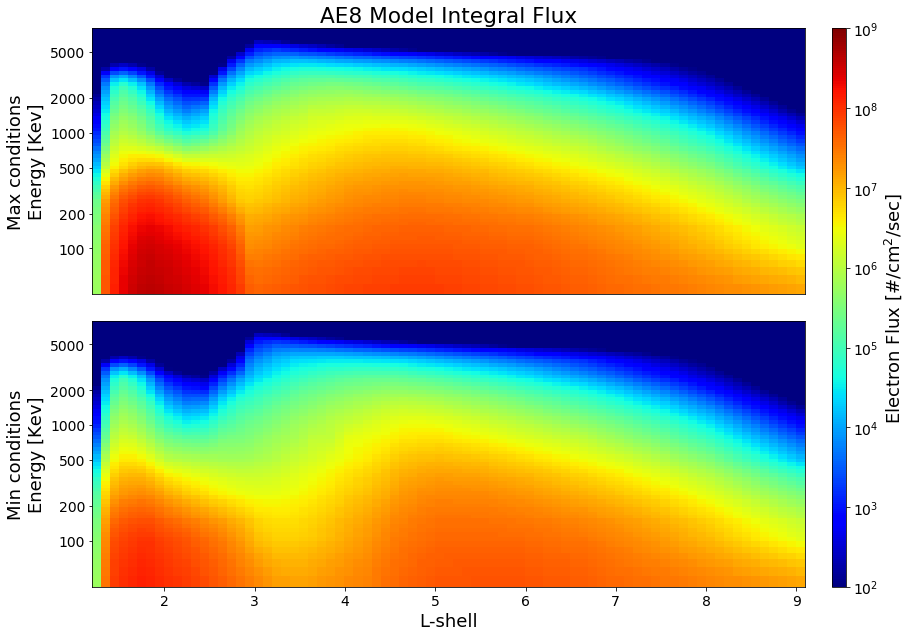

In [105]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

fluxfile = '/shared/users/asousa/WIPP/WIPP_stencils/data/AE8MAX_integral_flux_64_energies_8.dat'
Jdata = np.loadtxt(fluxfile)
JL = Jdata[1:,0]  # L-shells in J-file
JE = Jdata[0,1:]  # Energies in J-file
print "J is: ", np.shape(Jdata)
print np.shape(JL)  
print np.shape(JE)

Jmax = Jdata[1:,1:]
print np.shape(Jmax)
fluxfile = '/shared/users/asousa/WIPP/WIPP_stencils/data/AE8MIN_integral_flux_64_energies_8.dat'
Jdata = np.loadtxt(fluxfile)
Jmin = Jdata[1:,1:]

print np.log10(JE*1000.)

fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1, 0.02])
print gs
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
cbax = plt.subplot(gs[:,-1])
cmap = plt.get_cmap('jet')
clims = [2,9]
p0 =ax0.pcolor(JL, np.log10(JE*1000.), np.log10(Jmax.T), vmin=clims[0], vmax=clims[1], cmap = cmap)
p1 =ax1.pcolor(JL, np.log10(JE*1000.), np.log10(Jmin.T), vmin=clims[0], vmax=clims[1], cmap = cmap)

cb = plt.colorbar(p0, cax=cbax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Electron Flux [#/cm$^2$/sec]')
# cb.set_label('$\Phi$ [#/cm$^2$/keV/s]')


ax0.set_xticks([])
ax0.set_ylabel('Max conditions\nEnergy [Kev]')
ax1.set_ylabel('Min conditions\nEnergy [Kev]')
ax1.set_xlabel('L-shell')

ax0.set_yticks(np.log10([100, 200, 500, 1000, 2000, 5000]))
ax0.set_yticklabels([100, 200, 500, 1000, 2000, 5000])
ax1.set_yticks(np.log10([100, 200, 500, 1000, 2000, 5000]))
ax1.set_yticklabels([100, 200, 500, 1000, 2000, 5000])
fig.tight_layout()
ax0.set_title('AE8 Model Integral Flux')

fig.savefig('AE8_model_data.png',ldpi=300)

# ax[1].imshow(np.log10(Jmax.T), cmap = plt.get_cmap('jet'))

In [36]:
with gzip.open('phi_inlat_35.pklz','rb') as file:
    data = pickle.load(file)
print np.shape(data['phi_N'])
# fig, ax = plt.subplots(1,1)
# ax.plot(data['phi_N'].T)

(4, 10, 512)


In [44]:
with gzip.open('../outputs/crossings3/nightside/ngo_v2/python_data/crossing_log_lat_12-13_f_10030-11720.pklz','rb') as file:
    data = pickle.load(file)
print data.keys()
print data['Lshells']

['Lshells', 'fmin', 'fieldlines', 'fmax', 'lat_hi', 'lat_low', 'freq_pairs', 'time']
[ 1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6
  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6
  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9]
